In [1]:
import numpy as np
import pandas as pd
import string 

import re
import math
import collections
import matplotlib.pyplot as plt
%matplotlib inline

import gc
import sys

In [44]:
df_train = pd.read_table('news_data/news_train.txt', names=('label', 'title', 'text'))
df_test = pd.read_table('news_data/news_test.txt', names=('title', 'text'),encoding='utf-8')

In [77]:
split = 50000
df_test = df_train[split:]
df_train = df_train[:split]

In [45]:
df_train.head()

label                                              title  \
0      style                  Rolex наградит победителей регаты   
1      sport  Матс Сундин стал советником тренера сборной Шв...   
2      media    Брендом года по версии EFFIE впервые стал город   
3  economics  Цена нефти WTI снизилась после публикации данн...   
4  economics  Сбербанк распродаст другим банкирам миллиардны...   

                                                text  
0  Парусная гонка Giraglia Rolex Cup пройдет в Ср...  
1  Шведский хоккеист Матс Сундин назначен советни...  
2  Гран-при конкурса "Брэнд года/EFFIE" получил г...  
3  Цена американской нефти WTI на лондонской бирж...  
4  Сбербанк выставил на продажу долги по 21,4 тыс...

In [46]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 3 columns):
label    60000 non-null object
title    60000 non-null object
text     60000 non-null object
dtypes: object(3)
memory usage: 1.4+ MB


In [47]:
df_test.head()

title  \
0  В МИД Белоруссии одобрили вынос российского фл...   
1  Про Хана Соло и Бобу Фетта из «Звездных войн» ...   
2            В Рунете началась вирусная ICQ-эпидемия   
3  Шуховскую башню на Оке признали памятником фед...   
4  Голодец предупредила правительство о последств...   

                                                text  
0  Белорусский спортсмен, несший на открытии пара...  
1  Стало известно, кто именно будет центральными ...  
2  Тысячи пользователей стали жертвой нового ICQ-...  
3  Башня конструкции инженера Владимира Шухова в ...  
4  Вице-премьер правительства России Ольга Голоде...

In [48]:
labels_map = np.unique(df_train['label']) # index = codes
df_train['label'] = df_train['label'].astype('category').cat.codes

In [49]:
def tokenize(text):
    text = text.lower()
    text = re.sub(r"не ", "не_", text) 
    text = re.sub(r'\d', '0', text)
    
    
    # split into words by white space
    words = text.replace(',', ' ').replace('.', ' ').split(' ')
    # remove punctuation from each word
    table = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
    stripped = [w.translate(table).strip(' «»') for w in words]
    stem = [stemming(w) for w in stripped if len(w) > 0]
    
    return stem

def stemming(word):
    st = 4
    if len(word) >= st:
        word = word[:-int(len(word) / st)]
    return word 

In [50]:
df_train['text'] = df_train['text'].apply(tokenize)
df_train['title'] = df_train['title'].apply(tokenize)

df_test['text'] = df_test['text'].apply(tokenize)
df_test['title'] = df_test['title'].apply(tokenize)

In [51]:
df_train.head()

label                                              title  \
0      8                   [role, наград, победител, регат]   
1      7  [мат, сунди, ста, советник, тренер, сборно, шв...   
2      5  [брендо, год, по, верси, effi, впервы, ста, горо]   
3      2  [цен, нефт, wti, снизила, посл, публикац, данн...   
4      2  [сберба, распрода, други, банкир, миллиардн, д...   

                                                text  
0  [парусн, гонк, giragl, role, cup, пройде, в, с...  
1  [шведск, хоккеи, мат, сунди, назнач, советник,...  
2  [гран п, конкур, брэн, года eff, получи, горо,...  
3  [цен, американс, нефт, wti, на, лондонск, бирж...  
4  [сберба, выстав, на, продаж, долг, по, 00, 0, ...

In [52]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 3 columns):
label    60000 non-null int8
title    60000 non-null object
text     60000 non-null object
dtypes: int8(1), object(2)
memory usage: 996.2+ KB


In [53]:
def create_vocabulary(df):
    bag_of_words = {}
    words_in_documents = {}
    
    for text in (df['title'] + df['text']):
        for word in text:
            if word in bag_of_words:
                bag_of_words[word] += 1
            else:
                bag_of_words[word] = 1
                
        for word in np.unique(text):
            if word in words_in_documents:
                words_in_documents[word] += 1
            else:
                words_in_documents[word] = 1
    if '' in bag_of_words:
        bag_of_words.pop('')
        words_in_documents.pop('')
    return bag_of_words, words_in_documents

In [54]:
bag, wid = create_vocabulary(df_train)
print(len(wid), len(bag))

258258 258258


C:\Users\art18\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


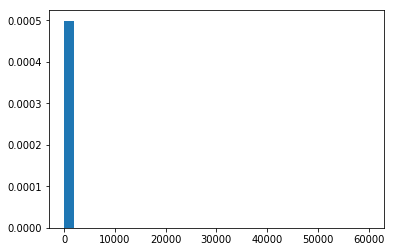

In [55]:
plt.hist(wid.values(), 30, normed=True)
plt.show()

In [56]:
sum(wid.values())

8210979

In [57]:
for_del = []
little = 0
many = 0
l = 300
h = 10000
for word in wid.keys():
    if wid[word] < l or wid[word] > h:
        #print(wid[word], word)
        for_del.append(word)
        if wid[word] < l:
            little += 1
        else:
            many += 1
            
        
for word in for_del:
    wid.pop(word)
    bag.pop(word)

print(len(wid), len(bag))
print('Меньше чем',l, ': ',  little)
print('Больше чем',h, ': ', many)

3814 3814
Меньше чем 300 :  254377
Больше чем 10000 :  67


In [58]:
class TfIdfVectorizer():
    def __init__(self, words_in_texts, word_in_documents, threshold=0.001):
        self.features = self.create_features(words_in_texts, word_in_documents, threshold)
        self.idf = self.compute_idf(word_in_documents, len(words_in_texts))
        
    def create_features(self, words_in_texts, word_in_documents, threshold=0.001):
        features = []
#         for words in words_in_texts:
#             tfidf = self.compute_tfidf(words, word_in_documents, len(words_in_texts))
#             for word in tfidf:
#                 if tfidf[word] > threshold and word not in features:
#                     features.append(word)
#                     if len(features) % 10000 == 0:
#                         print(len(features))

        features = word_in_documents.keys()
        return features
    
    def compute_tfidf(self, words, word_in_documents, len_docs):
        tf_text = collections.Counter(words)
        for i in tf_text:
            if i in word_in_documents:
                tf_text[i] = tf_text[i]/float(len(words)) * (math.log(len_docs / word_in_documents[i]))
            else:
                tf_text[i] = 0
        return tf_text
    
    def compute_idf(self, word_in_documents, len_docs):
        idf = {}
        for feature in self.features:
            idf[feature] = math.log(len_docs / word_in_documents[feature])
        return idf
    
    def vectorize_words(self, words):
        vec = dict.fromkeys(self.features, 0)
        
        tf_text = collections.Counter(words)
        for word in tf_text:
            if word in self.features:
                vec[word] = tf_text[word]/float(len(words)) * self.idf[word]
    
        vec = np.array(list(vec.values()))
        return vec
    
    def vectorize(self, df_text):
        v = np.array([self.vectorize_words(words) for words in df_text])
        return v 

In [59]:
X_train = (df_train['title'] + df_train["text"])
X_test = (df_test['title'] + df_test["text"])
y_train = df_train["label"].tolist()
# line = 45000
# X_train = X_train[:line]
# X_test  = X_train[line:]
# y_test = y_train[line:]
# y_train = y_train[:line]

In [68]:
%%time
tfidf = TfIdfVectorizer(X_train, wid, threshold=0.02)
print(len(tfidf.features))

3814
Wall time: 21 ms


In [61]:
%%time
X_train_counts = tfidf.vectorize(X_train)

Wall time: 7min 1s


In [62]:
def accuracy(y, y_pred):
    return sum(y == y_pred) / len(y)

def MSE(y_pred, y):
    return np.mean(np.square(np.subtract(y, y_pred)))

def sigmoid(x):
    return 1/(1 + np.exp(-x))

def softmax(x):
    z = x - max(x)
    numerator = np.exp(z)
    denominator = np.sum(numerator)
    softmax = numerator/denominator
    return softmax

def logloss(y, y_pred, eps=1e-15):
    y_p = np.clip(y_pred, eps, 1 - eps)
    return - y*np.log(y_p) - (1-y)*(np.log(1-y_p))

def dlogloss_dy(y, y_pred, eps=1e-15):
    y_p = np.clip(y_pred, eps, 1 - eps)
    return - y*(1/y_p) + (1-y)*1/(1-y_p)

In [63]:
class LogReg():
    def __init__(self):
        self.weights = None
        
    def active(self, x):
        return softmax(x)
    
    def fit(self, X, y, eta=1e-2, n_classes=10, max_iter=10):
        history = []
        N = X.shape[0]
        b = np.ones((N,1))          #add bias
        X_bias = np.hstack((X,b))
        
        n_features = X_bias.shape[1]
        
        if self.weights is None:
            self.weights = np.random.randn(n_classes, n_features)
            
        print("Train on ", N, "x", n_features)
        print("Start training")
        for i in range(max_iter):
            running_loss = 0.0
            print("Iteration -", i)
            for j in range(N):
                
                sample, label = X_bias[j], y[j]
                
                #label 2 vector
                y_true = np.zeros(n_classes)
                y_true[label] = 1
                
                #calculate prediction
                z = np.matmul(self.weights, sample.T)
                y_pred = self.active(z)
                
                loss = logloss(y_true, y_pred)
                running_loss += np.mean(loss)
                
                #calculate gradient
                dsigm_dz = y_pred * (1 - y_pred)
                grad = np.outer(dlogloss_dy(y_true, y_pred) * dsigm_dz, sample)
                
                self.weights -= eta * grad
                
                if j % 20000 == 19999:
                    history.append(running_loss/1000)
                    #print("[{} - {}] loss: {:.5}".format(i,j,running_loss/1000))
                    running_loss = 0.0
        return history
    
    def predict(self, X):
        N = X.shape[0]
        
        b = np.ones((N,1))          #add bias
        X_bias = np.hstack((X,b))
        
        y = np.zeros(N)
        
        for i,sample in enumerate(X_bias):
            z = np.matmul(self.weights, sample.T)
            y_pred = self.active(z)
            label = y_pred.argmax()
            y[i] = label

        return y

In [64]:
clf = LogReg()

Train on  50000 x 3265
Start training
Iteration - 0
Iteration - 1
Iteration - 2
Iteration - 3
Iteration - 4
Iteration - 5
Iteration - 6
Iteration - 7
Iteration - 8
Iteration - 9
loss =  4.832153130996426
Wall time: 2min 35s


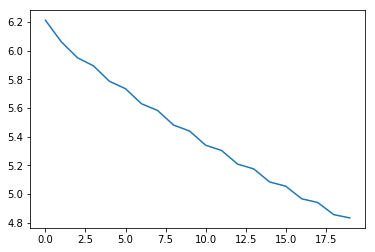

In [24]:
%%time
history = clf.fit(X_train_counts, y_train)
plt.plot(history)
print("loss = ", history[-1])

Train on  50000 x 3265
Start training
Iteration - 0
Iteration - 1
Iteration - 2
Iteration - 3
Iteration - 4
Iteration - 5
Iteration - 6
Iteration - 7
Iteration - 8
Iteration - 9
Iteration - 10
Iteration - 11
Iteration - 12
Iteration - 13
Iteration - 14
Iteration - 15
Iteration - 16
Iteration - 17
Iteration - 18
Iteration - 19
loss =  1.7690099418420315
Wall time: 4min 16s


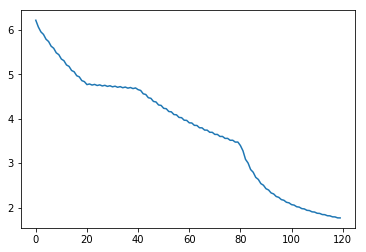

In [27]:
%%time
h2 = clf.fit(X_train_counts, y_train, eta=0.1, max_iter= 20)
history.extend(h2)
plt.plot(history)
print("loss = ", history[-1])

Train on  50000 x 3265
Start training
Iteration - 0
Iteration - 1
Iteration - 2
Iteration - 3
Iteration - 4
Iteration - 5
Iteration - 6
Iteration - 7
Iteration - 8
Iteration - 9
Iteration - 10
Iteration - 11
Iteration - 12
Iteration - 13
Iteration - 14
Iteration - 15
Iteration - 16
Iteration - 17
Iteration - 18
Iteration - 19
Iteration - 20
Iteration - 21
Iteration - 22
Iteration - 23
Iteration - 24
Iteration - 25
Iteration - 26
Iteration - 27
Iteration - 28
Iteration - 29
loss =  1.6845503028102713
Wall time: 7min 19s


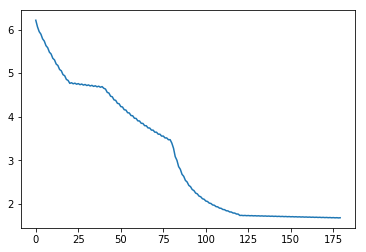

In [28]:
%%time
h2 = clf.fit(X_train_counts, y_train, eta=0.01, max_iter= 30)
history.extend(h2)
plt.plot(history)
print("loss = ", history[-1])

Train on  50000 x 3265
Start training
Iteration - 0
Iteration - 1
Iteration - 2
Iteration - 3
Iteration - 4
Iteration - 5
Iteration - 6
Iteration - 7
Iteration - 8
Iteration - 9
Iteration - 10
Iteration - 11
Iteration - 12
Iteration - 13
Iteration - 14
Iteration - 15
Iteration - 16
Iteration - 17
Iteration - 18
Iteration - 19
Iteration - 20
Iteration - 21
Iteration - 22
Iteration - 23
Iteration - 24
Iteration - 25
Iteration - 26
Iteration - 27
Iteration - 28
Iteration - 29
loss =  1.4033037357813234
Wall time: 10min 48s


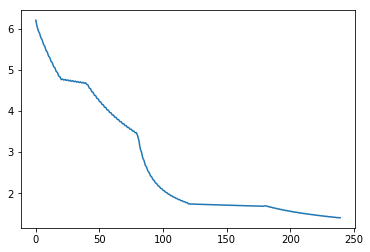

In [29]:
%%time
h2 = clf.fit(X_train_counts, y_train, eta=0.1, max_iter= 30)
history.extend(h2)
plt.plot(history)
print("loss = ", history[-1])

Train on  60000 x 3815
Start training
Iteration - 0
Iteration - 1
Iteration - 2
Iteration - 3
Iteration - 4
Iteration - 5
Iteration - 6
Iteration - 7
Iteration - 8
Iteration - 9
Iteration - 10
Iteration - 11
Iteration - 12
Iteration - 13
Iteration - 14
Iteration - 15
Iteration - 16
Iteration - 17
Iteration - 18
Iteration - 19
loss =  4.554188008075117
Wall time: 4min 49s


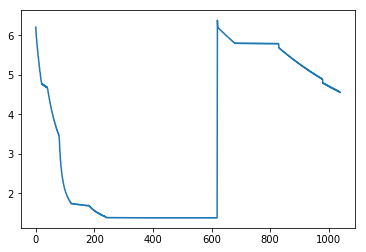

In [72]:
%%time
h2 = clf.fit(X_train_counts, y_train, eta=0.001, max_iter= 20)
history.extend(h2)
plt.plot(history)
print("loss = ", history[-1])

Train on  60000 x 3815
Start training
Iteration - 0
Iteration - 1
Iteration - 2
Iteration - 3
Iteration - 4
Iteration - 5
Iteration - 6
Iteration - 7
Iteration - 8
Iteration - 9
Iteration - 10
Iteration - 11
Iteration - 12
Iteration - 13
Iteration - 14
Iteration - 15
Iteration - 16
Iteration - 17
Iteration - 18
Iteration - 19
Iteration - 20
Iteration - 21
Iteration - 22
Iteration - 23
Iteration - 24
Iteration - 25
Iteration - 26
Iteration - 27
Iteration - 28
Iteration - 29
Iteration - 30
Iteration - 31
Iteration - 32
Iteration - 33
Iteration - 34
Iteration - 35
Iteration - 36
Iteration - 37
Iteration - 38
Iteration - 39
Iteration - 40
Iteration - 41
Iteration - 42
Iteration - 43
Iteration - 44
Iteration - 45
Iteration - 46
Iteration - 47
Iteration - 48
Iteration - 49
loss =  5.791834847174218
Wall time: 34min 13s


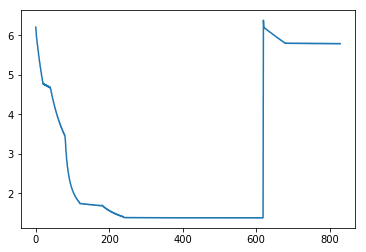

In [66]:
%%time
h2 = clf.fit(X_train_counts, y_train, eta=0.00001, max_iter= 50)
history.extend(h2)
plt.plot(history)
print("loss = ", history[-1])

In [ ]:
%%time
h2 = clf.fit(X_train_counts, y_train, eta=0.001, max_iter= 15)
history.extend(h2)
plt.plot(history)
print("loss = ", history[-1])

In [78]:
%%time
X_test_counts = tfidf.vectorize(X_test)

Wall time: 32.5 s


In [79]:
%%time
y_pred = clf.predict(X_test_counts)

Wall time: 1.43 s


In [82]:
len(y_pred)

15000

In [80]:
y_pred = [labels_map[int(x)] for x in y_pred]

In [81]:
true = 0
false = 0
y = df_test['label'].tolist()
for i in range(len(y)):
    if y[i] == y_pred[i]:
        true +=1
    else:
        false += 1
print('True ', true)
print('False ', false)
    

True  0
False  10000


In [76]:
with open('submission.txt', 'w') as f:
    f.write('\n'.join(y_pred))

In [ ]:
1406 - best
1600 on task